In [1]:
import keras
import numpy as np
from keras.models import Sequential, Model
from keras.layers import Dense, Reshape, Flatten, Input, Dropout, LSTM, MultiHeadAttention, GlobalAveragePooling1D
from keras.optimizers import Adam, SGD, RMSprop
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import os
import matplotlib.lines as mlines
from tensorflow.keras import layers

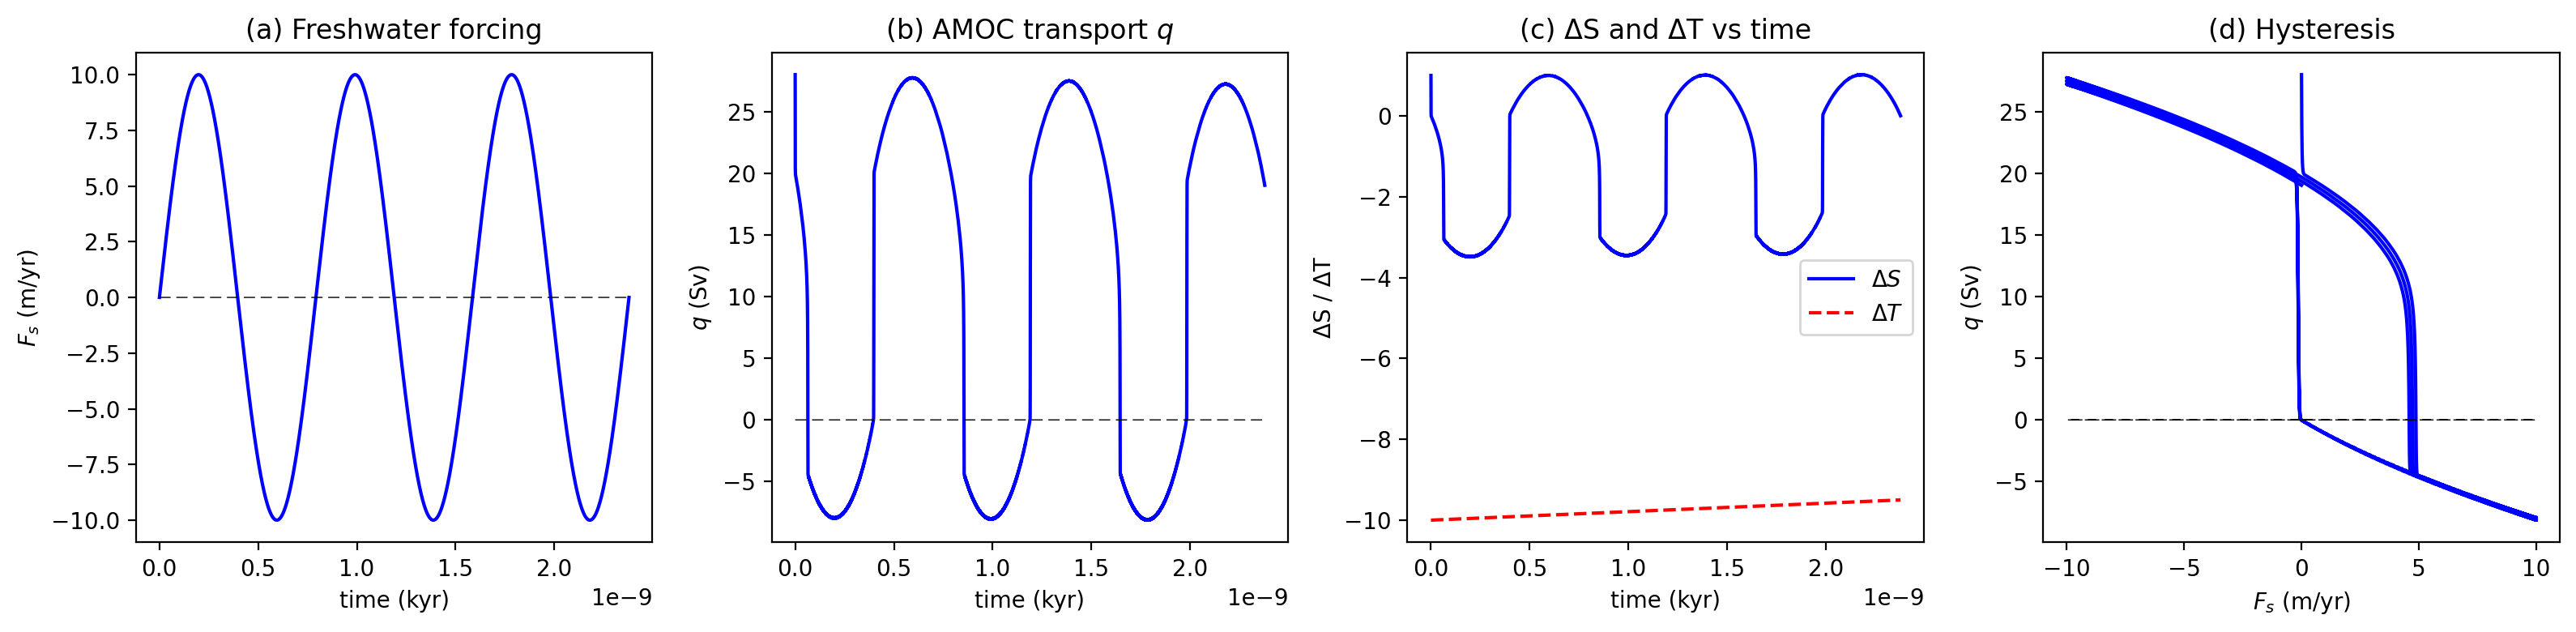

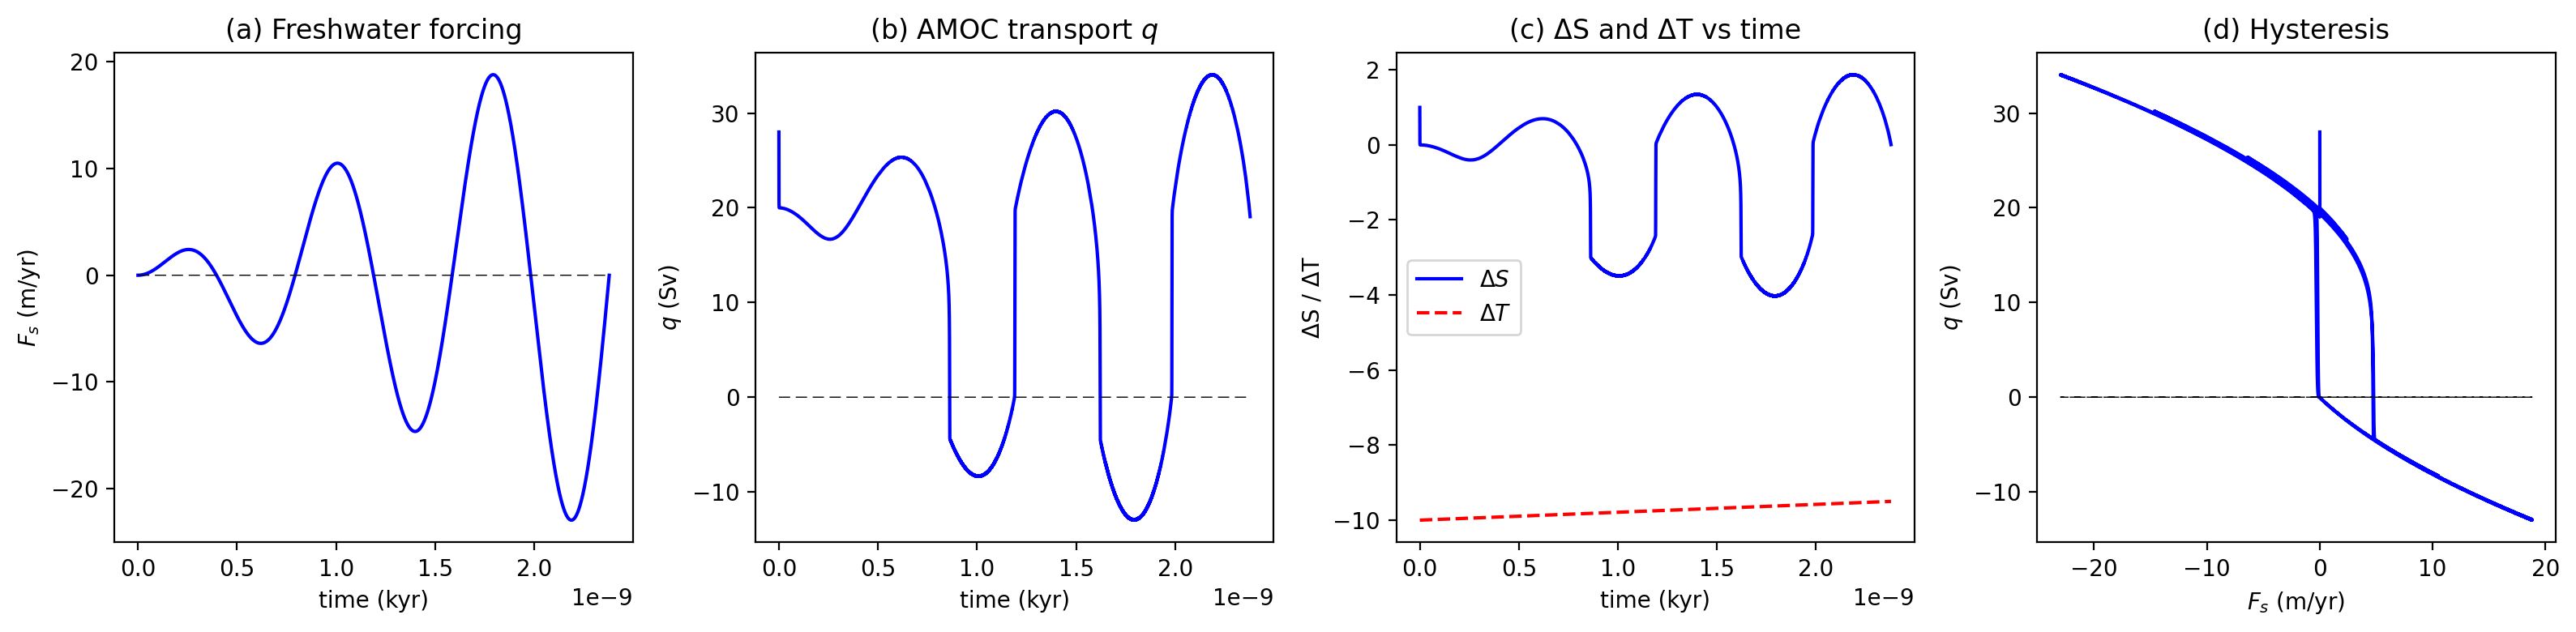

In [2]:
%run 00_generate_data.ipynb

# STATIONARY CASE

In [3]:
input_data, output_data, qplot = get_data("s")

In [4]:
X_train = input_data[0:60032]
y_train = output_data[0:60032]

X_val = input_data[61024:81000]
y_val = output_data[61024:81000]

X_test = input_data[81992:100000]
y_test = output_data[81992:100000]

scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)
input_scaled = scaler.transform(input_data)

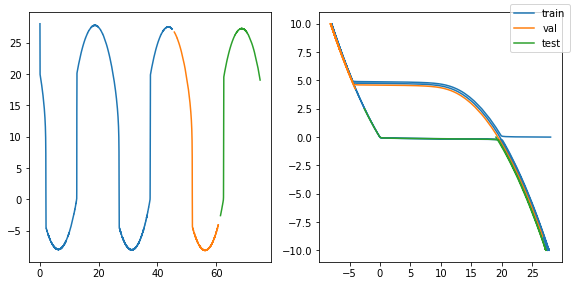

In [193]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].plot(X_train[:, 0], qplot[0:60032]/Sv);
ax[0].plot(X_val[:, 0], qplot[61024:81000]/Sv);
ax[0].plot(X_test[:, 0], qplot[81992:100000]/Sv);
ax[1].plot(qplot[0:60032]/Sv, input_data[:, 3][0:60032]/Fs_to_m_per_year, label='train');
ax[1].plot(qplot[61024:81000]/Sv, input_data[:,3][61024:81000]/Fs_to_m_per_year, label='val');
ax[1].plot(qplot[81992:100000]/Sv, input_data[:, 3][81992:100000]/Fs_to_m_per_year, label='test');
fig.legend();
fig.tight_layout()

In [5]:
def create_sequences(data, labels, time_steps):
    sequences, sequence_labels = [], []
    for i in range(len(data) - time_steps + 1):
        sequences.append(data[i:i + time_steps])
        sequence_labels.append(labels[i + time_steps - 1])  # Label at the end of the sequence
    return np.array(sequences), np.array(sequence_labels)

time_steps = 16
feature_dim = 4

# Create sequences
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train, time_steps)
X_val_seq, y_val_seq = create_sequences(X_val_scaled, y_val, time_steps)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test, time_steps)
input_seq, output_seq = create_sequences(input_scaled, output_data, time_steps)

In [6]:
def build_transformer():
    inputs = Input(shape=(None, feature_dim))  # None allows variable sequence length
    
   
    attention_output = MultiHeadAttention(
        num_heads=4,
        key_dim=4,
        dropout=0.1
    )(inputs, inputs)  

    pooled = GlobalAveragePooling1D()(attention_output)

    x = Dense(16, activation='relu')(pooled)
    x = Dense(8, activation='relu')(x)
    x = Dense(4, activation='relu')(x)
    x = Dense(2, activation='relu')(x)
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=inputs, outputs=outputs)
    
    return model 

In [7]:
model = build_transformer()

In [32]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [33]:
model_eval = model.fit(X_train_seq, y_train_seq,
                    batch_size=64,
                    epochs=10,
                    verbose=1,
                    validation_data=(X_val_seq, y_val_seq))

Epoch 1/10
938/938 [==============================] - 5s 4ms/step - loss: 0.3082 - accuracy: 0.9683 - val_loss: 0.1459 - val_accuracy: 0.9895
Epoch 2/10
938/938 [==============================] - 4s 4ms/step - loss: 0.1336 - accuracy: 0.9982 - val_loss: 0.0734 - val_accuracy: 0.9995
Epoch 3/10
938/938 [==============================] - 3s 4ms/step - loss: 0.0773 - accuracy: 0.9983 - val_loss: 0.0435 - val_accuracy: 0.9997
Epoch 4/10
938/938 [==============================] - 3s 3ms/step - loss: 0.0484 - accuracy: 0.9985 - val_loss: 0.0273 - val_accuracy: 0.9997
Epoch 5/10
938/938 [==============================] - 3s 3ms/step - loss: 0.0315 - accuracy: 0.9987 - val_loss: 0.0180 - val_accuracy: 0.9996
Epoch 6/10
938/938 [==============================] - 3s 4ms/step - loss: 0.0213 - accuracy: 0.9989 - val_loss: 0.0115 - val_accuracy: 0.9999
Epoch 7/10
938/938 [==============================] - 3s 4ms/step - loss: 0.0154 - accuracy: 0.9988 - val_loss: 0.0080 - val_accuracy: 0.9997
Epoch 

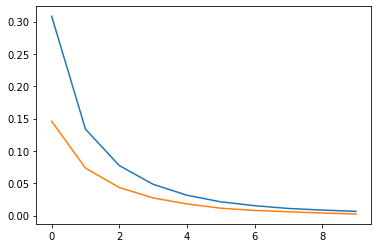

In [34]:
plt.plot(model_eval.history['loss'])
plt.plot(model_eval.history['val_loss'])

In [35]:
loss, accuracy= model.evaluate(X_test_seq, y_test_seq)

563/563 [==============================] - 1s 2ms/step - loss: 0.0159 - accuracy: 0.9943


In [36]:
predicted = model.predict(input_seq)
predicted_labels = (predicted > 0.5).astype(int)
false_indices = np.where(predicted_labels[:, 0] != output_seq)

3125/3125 [==============================] - 4s 1ms/step


Text(0, 0.5, 'Circulation (Sv)')

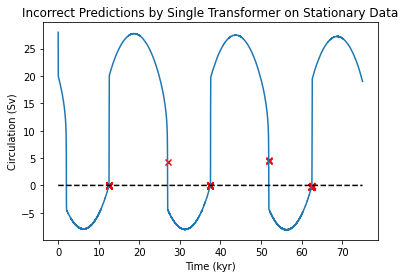

In [37]:
fig, ax = plt.subplots()
ax.plot(input_data[:, 0], qplot/Sv)
ax.plot(input_data[:, 0], np.zeros_like(input_data[:, 0]), 'k--')
ax.set_title('Incorrect Predictions by Single Transformer on Stationary Data')
ax.scatter(input_data[false_indices, 0], qplot[false_indices]/Sv, marker='x', c='red')
ax.set_xlabel('Time (kyr)')
ax.set_ylabel('Circulation (Sv)')

In [41]:
training_losses = np.zeros(12, dtype=np.ndarray)
validation_losses = np.zeros(12, dtype=np.ndarray)

In [48]:
# training the ensemble 
for i in range(12):
    print(i)
    es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
    model = build_transformer()
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model_eval = model.fit(X_train_seq, y_train_seq,
                    batch_size=64,
                    epochs=10,
                    verbose=0,
                    validation_data=(X_val_seq, y_val_seq),
                    callbacks=[es])#,
    training_losses[i] = model_eval.history['loss']
    validation_losses[i] = model_eval.history['val_loss']
    model.save('models/transformer/stationary/ensemble_member_'+str(i)+'.keras')

0
Epoch 9: early stopping
1
2
3
Epoch 9: early stopping
4
5
6
7
8
9
10
11


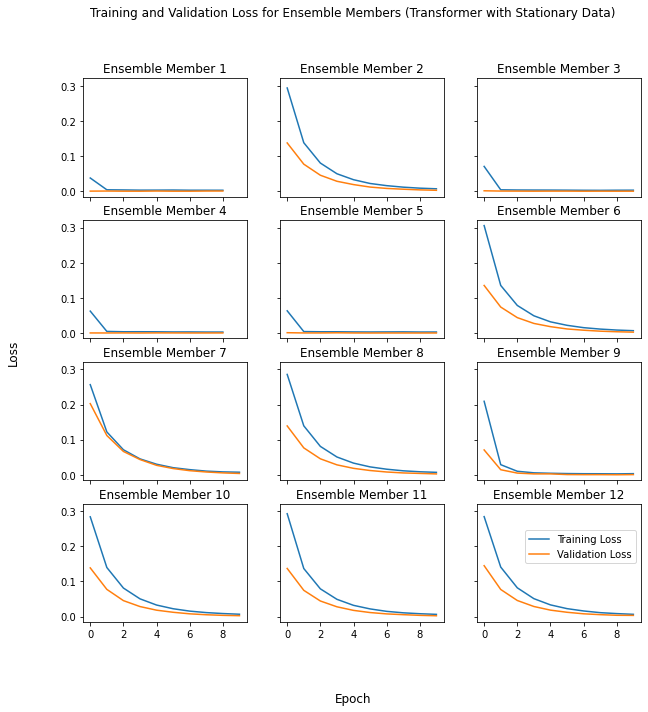

In [49]:
fig, ax = plt.subplots(4, 3, sharex = True, sharey = True, figsize = (10, 10));
fig.supxlabel('Epoch');
fig.supylabel('Loss');
fig.suptitle('Training and Validation Loss for Ensemble Members (Transformer with Stationary Data)');
ax = ax.flatten();
for i in range(12):
    ax[i].plot(training_losses[i], label='Training Loss')
    ax[i].plot(validation_losses[i], label='Validation Loss')
    ax[i].set_title('Ensemble Member ' + str(i+1))
fig.legend(
    labels=['Training Loss', 'Validation Loss'],
    loc='lower right',
    bbox_to_anchor=(0.9, 0.2) 
)
fig.savefig('figures/training/losses_transformer_s.pdf')

In [8]:
accuracies = []
predicted_results_ensemble = np.nan * np.zeros((12, input_seq.shape[0], 1))

for i in range(12):
    print(i)
    model = build_transformer()
    model.load_weights('models/transformer/stationary/ensemble_member_'+str(i)+'.keras')
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    loss, accuracy= model.evaluate(X_test_seq, y_test_seq)
    accuracies.append(accuracy)
    print(f'Test loss: {loss}')
    print(f'Test accuracy: {accuracy}')
    predicted = model.predict(input_seq)
    predicted_results_ensemble[i,...] = predicted

0
563/563 [==============================] - 1s 2ms/step - loss: 0.0044 - accuracy: 0.9981
Test loss: 0.004426704719662666
Test accuracy: 0.9980548024177551
3125/3125 [==============================] - 4s 1ms/step
1
563/563 [==============================] - 1s 2ms/step - loss: 0.0318 - accuracy: 0.9871
Test loss: 0.03181120380759239
Test accuracy: 0.9871060848236084
3125/3125 [==============================] - 5s 2ms/step
2
563/563 [==============================] - 1s 2ms/step - loss: 0.0031 - accuracy: 0.9996
Test loss: 0.0030914777889847755
Test accuracy: 0.999610960483551
3125/3125 [==============================] - 5s 1ms/step
3
563/563 [==============================] - 1s 1ms/step - loss: 0.0039 - accuracy: 0.9999
Test loss: 0.003927482292056084
Test accuracy: 0.9999444484710693
3125/3125 [==============================] - 5s 1ms/step
4
563/563 [==============================] - 1s 2ms/step - loss: 0.0094 - accuracy: 0.9945
Test loss: 0.009369347244501114
Test accuracy: 0.99449

In [10]:
print('ensemble accuracy: ' + str(sum(accuracies)/12*100))

ensemble accuracy: 99.50258433818817


In [11]:
predicted_all = np.mean(predicted_results_ensemble, axis=0).reshape(-1)
predicted_labels = (predicted_all > 0.5).astype(int)
false_indices = np.where(predicted_labels != output_seq)

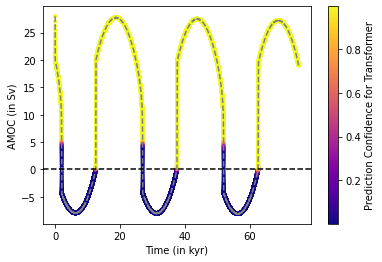

In [23]:
# Plot the baseline line
plt.plot(input_data[:, 0], qplot / Sv, color='grey', linestyle='--', label="qplot/Sv")

# Scatter the same curve, but color by predicted probabilities
sc = plt.scatter(input_data[0:99985, 0], qplot[0:99985] / Sv, 
                 c=predicted_all[0:99985], cmap="plasma", s=10)

# Add colorbar for the probabilities
plt.colorbar(sc, label="Prediction Confidence for Transformer")
plt.axhline(y=0, color='black', linestyle='dashed');

plt.xlabel("Time (in kyr)")
plt.ylabel("AMOC (in Sv)")
#plt.legend()
plt.show()

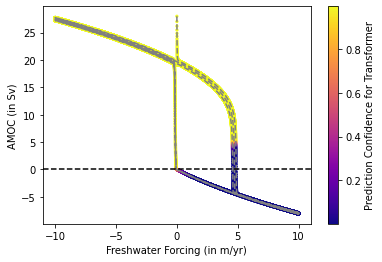

In [22]:
# Plot the baseline line
plt.plot(input_data[:, 3]/Fs_to_m_per_year, qplot / Sv, color='grey', linestyle='--', label="qplot/Sv")

# Scatter the same curve, but color by predicted probabilities
sc = plt.scatter(input_data[0:99985, 3]/Fs_to_m_per_year, qplot[0:99985] / Sv, 
                 c=predicted_all[0:99985], cmap="plasma", s=5)

# Add colorbar for the probabilities
plt.colorbar(sc, label="Prediction Confidence for Transformer")
plt.axhline(y=0, color='black', linestyle='dashed');

plt.xlabel("Freshwater Forcing (in m/yr)")
plt.ylabel("AMOC (in Sv)")
#plt.legend()
plt.show()

In [ ]:
# Plot the baseline line
plt.plot(input_data[:, 0], qplot / Sv, color='grey', linestyle='--', label="qplot/Sv")

# Scatter the same curve, but color by predicted probabilities
sc = plt.scatter(input_data[0:99985, 0], qplot[0:99985] / Sv, 
                 c=predicted_all[0:99985], cmap="plasma", s=10)

# Add colorbar for the probabilities
plt.colorbar(sc, label="Prediction Confidence for LSTM (sigmoid output)")

plt.xlabel("Time (in kyr)")
plt.ylabel("AMOC (in Sv)")
#plt.legend()
plt.show()

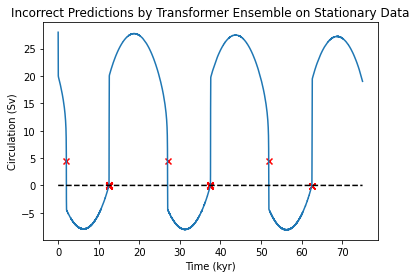

In [185]:
fig, ax = plt.subplots()
ax.plot(input_data[:, 0], qplot/Sv)
ax.plot(input_data[:, 0], np.zeros_like(input_data[:, 0]), 'k--')
ax.set_title('Incorrect Predictions by Transformer Ensemble on Stationary Data')
ax.scatter(input_data[false_indices, 0], qplot[false_indices]/Sv, marker='x', c='red')
ax.set_xlabel('Time (kyr)')
ax.set_ylabel('Circulation (Sv)')
fig.savefig('figures/training/preds_all_transformer_s.pdf')

In [188]:
false_indices[0]

array([ 2686, 16664, 16665, 16666, 16667, 16668, 16669, 16670, 16671,
       16672, 16673, 16674, 16675, 16676, 16677, 16678, 16679, 16680,
       16681, 16682, 16683, 16684, 16685, 16686, 16687, 16688, 16689,
       16690, 16691, 16692, 16693, 16694, 16695, 16696, 35930, 49991,
       49992, 49993, 49994, 49995, 49996, 49997, 49998, 49999, 50000,
       50001, 50002, 50003, 50004, 50005, 50006, 50007, 50008, 50009,
       50010, 50011, 50012, 50013, 50014, 50015, 50016, 50017, 50018,
       50019, 50020, 50021, 50022, 50023, 69177, 83328, 83329, 83330,
       83331])

In [189]:
test_indices = set(range(81992, 100000))
wrong_in_test = list(set(false_indices[0]) & test_indices)
np.save('incorrect_indices_transformer_s', np.array(wrong_in_test))

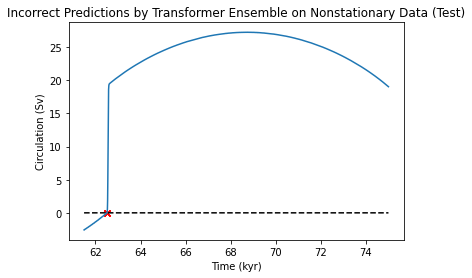

In [190]:
fig, ax = plt.subplots()
ax.plot(X_test[:, 0], np.zeros_like(X_test[:, 0]), 'k--')
ax.plot(X_test[:, 0], qplot[81992:100000]/Sv);
ax.set_title('Incorrect Predictions by Transformer Ensemble on Nonstationary Data (Test)');
ax.scatter(input_data[wrong_in_test, 0], qplot[wrong_in_test]/Sv, marker='x', c='red');
ax.set_xlabel('Time (kyr)');
ax.set_ylabel('Circulation (Sv)');

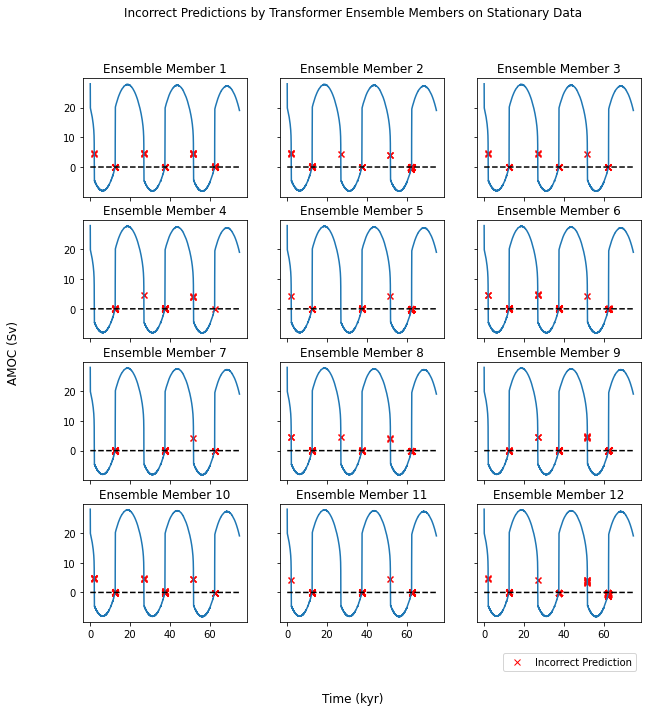

In [54]:
fig, ax = plt.subplots(4, 3, sharex = True, sharey = True, figsize = (10, 10))
fig.supxlabel('Time (kyr)')
fig.supylabel('AMOC (Sv)')
fig.suptitle('Incorrect Predictions by Transformer Ensemble Members on Stationary Data')
ax = ax.flatten()
for i in range(12):
    ensemble_i_pred = (predicted_results_ensemble[i] > 0.5).astype(int)
    false_indices = []
    for j in range(len(ensemble_i_pred)):
        if ensemble_i_pred[j] != output_seq[j]:
            false_indices.append(j)
    ax[i].plot(input_data[:, 0], qplot/Sv);
    ax[i].plot(input_data[:, 0], input_data[:, 0]*0,'k--');
    ax[i].set_title('Ensemble Member ' + str(i+1));
    ax[i].scatter([input_data[:, 0][k] for k in false_indices], [qplot[k]/Sv for k in false_indices], marker='x', c='red');
red_x = mlines.Line2D([], [], color='red', marker='x', linestyle='None', label='Incorrect Prediction')
fig.legend(handles=[red_x], loc='lower right', bbox_to_anchor=(0.9, 0.05))
fig.savefig('figures/training/preds_ensemble_transformer_s.pdf')

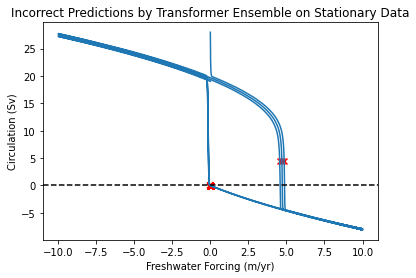

In [200]:
fig, ax = plt.subplots()
ax.plot(input_data[:, 3]/Fs_to_m_per_year, qplot/Sv)
ax.axhline(0, color='black', linestyle='--');
ax.set_title('Incorrect Predictions by Transformer Ensemble on Stationary Data')
ax.scatter(input_data[false_indices, 3]/Fs_to_m_per_year, qplot[false_indices]/Sv, marker='x', c='red')
ax.set_xlabel('Freshwater Forcing (m/yr)')
ax.set_ylabel('Circulation (Sv)')
fig.savefig('figures/training/preds_all_transformer_s_hysteresis.pdf')

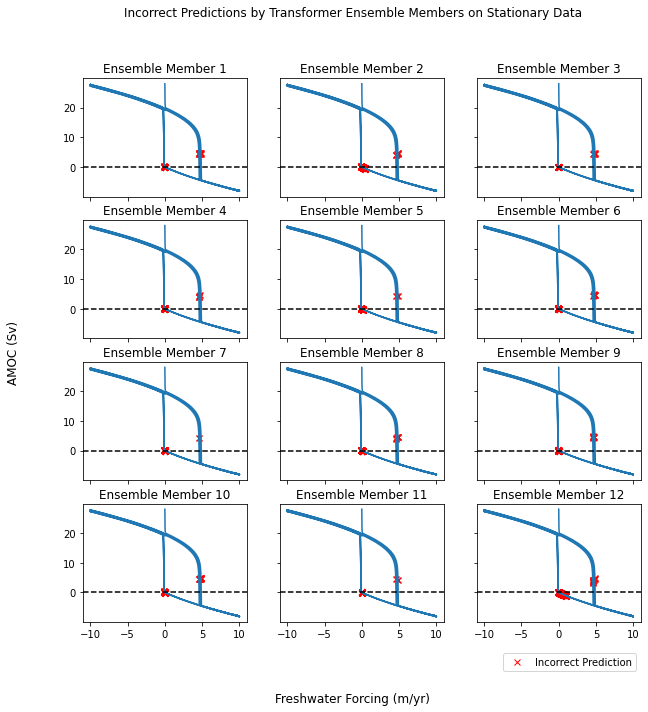

In [201]:
fig, ax = plt.subplots(4, 3, sharex = True, sharey = True, figsize = (10, 10))
fig.supxlabel('Freshwater Forcing (m/yr)')
fig.supylabel('AMOC (Sv)')
fig.suptitle('Incorrect Predictions by Transformer Ensemble Members on Stationary Data')
ax = ax.flatten()
for i in range(12):
    ensemble_i_pred = (predicted_results_ensemble[i] > 0.5).astype(int)
    false_indices = []
    for j in range(len(ensemble_i_pred)):
        if ensemble_i_pred[j] != output_seq[j]:
            false_indices.append(j)
    ax[i].plot(input_data[:, 3]/Fs_to_m_per_year, qplot/Sv);
    ax[i].axhline(0, color='black', linestyle='--');
    ax[i].set_title('Ensemble Member ' + str(i+1));
    ax[i].scatter([input_data[:, 3][k]/Fs_to_m_per_year for k in false_indices], [qplot[k]/Sv for k in false_indices], marker='x', c='red');
red_x = mlines.Line2D([], [], color='red', marker='x', linestyle='None', label='Incorrect Prediction')
fig.legend(handles=[red_x], loc='lower right', bbox_to_anchor=(0.9, 0.05))
fig.savefig('figures/training/preds_ensemble_transformer_s_hysteresis.pdf')

# NONSTATIONARY CASE

In [202]:
input_data, output_data, qplot = get_data("ns")

In [203]:
X_train = input_data[0:60032]
y_train = output_data[0:60032]

X_val = input_data[61024:81000]
y_val = output_data[61024:81000]

X_test = input_data[81992:100000]
y_test = output_data[81992:100000]

scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)
input_scaled = scaler.transform(input_data)

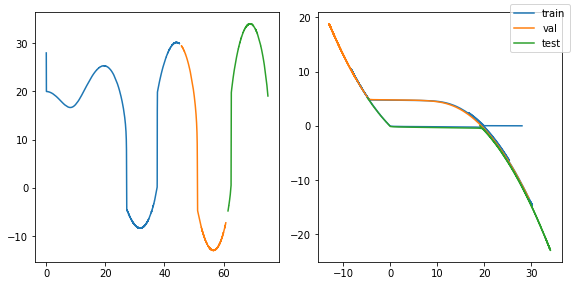

In [204]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].plot(X_train[:, 0], qplot[0:60032]/Sv);
ax[0].plot(X_val[:, 0], qplot[61024:81000]/Sv);
ax[0].plot(X_test[:, 0], qplot[81992:100000]/Sv);
ax[1].plot(qplot[0:60032]/Sv, input_data[:, 3][0:60032]/Fs_to_m_per_year, label='train');
ax[1].plot(qplot[61024:81000]/Sv, input_data[:,3][61024:81000]/Fs_to_m_per_year, label='val');
ax[1].plot(qplot[81992:100000]/Sv, input_data[:, 3][81992:100000]/Fs_to_m_per_year, label='test');
fig.legend();
fig.tight_layout()

In [205]:
def create_sequences(data, labels, time_steps):
    sequences, sequence_labels = [], []
    for i in range(len(data) - time_steps + 1):
        sequences.append(data[i:i + time_steps])
        sequence_labels.append(labels[i + time_steps - 1])  # Label at the end of the sequence
    return np.array(sequences), np.array(sequence_labels)

time_steps = 64
feature_dim = 4

# Create sequences
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train, time_steps)
X_val_seq, y_val_seq = create_sequences(X_val_scaled, y_val, time_steps)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test, time_steps)
input_seq, output_seq = create_sequences(input_scaled, output_data, time_steps)

In [120]:
training_losses = np.zeros(12, dtype=np.ndarray)
validation_losses = np.zeros(12, dtype=np.ndarray)

In [121]:
# training the ensemble 
for i in range(12):
    print(i)
    es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
    model = build_transformer()
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model_eval = model.fit(X_train_seq, y_train_seq,
                    batch_size=128,
                    epochs=10,
                    verbose=0,
                    validation_data=(X_val_seq, y_val_seq),
                    callbacks=[es])#,
    training_losses[i] = model_eval.history['loss']
    validation_losses[i] = model_eval.history['val_loss']
    model.save('models/transformer/nonstationary/ensemble_member_'+str(i)+'.keras')

0
Epoch 7: early stopping
1
Epoch 7: early stopping
2
Epoch 6: early stopping
3
4
5
6
7
8
9
10
11


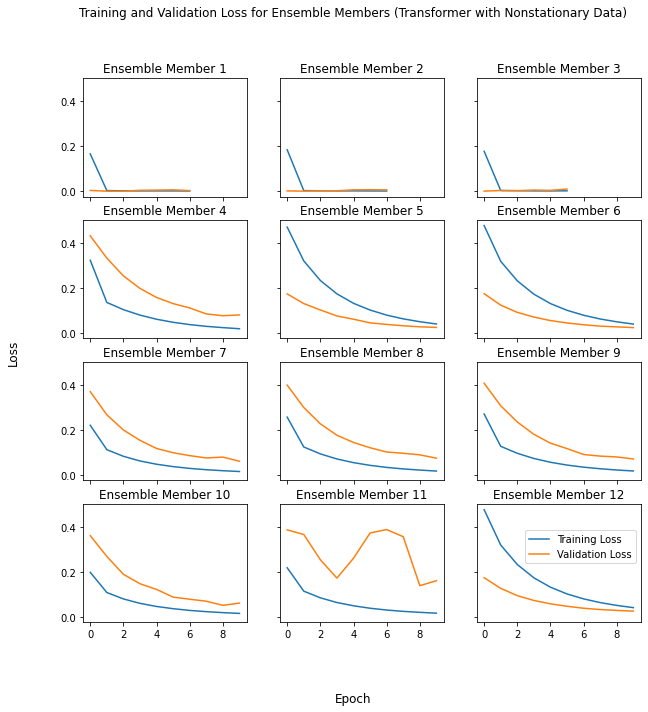

In [122]:
fig, ax = plt.subplots(4, 3, sharex = True, sharey = True, figsize = (10, 10));
fig.supxlabel('Epoch');
fig.supylabel('Loss');
fig.suptitle('Training and Validation Loss for Ensemble Members (Transformer with Nonstationary Data)');
ax = ax.flatten();
for i in range(12):
    ax[i].plot(training_losses[i], label='Training Loss')
    ax[i].plot(validation_losses[i], label='Validation Loss')
    ax[i].set_title('Ensemble Member ' + str(i+1))
fig.legend(
    labels=['Training Loss', 'Validation Loss'],
    loc='lower right',
    bbox_to_anchor=(0.9, 0.2) 
)
fig.savefig('figures/training/losses_transformer_ns_final.pdf')

In [206]:
accuracies = []
predicted_results_ensemble = np.nan * np.zeros((12, input_seq.shape[0], 1))

for i in range(12):
    print(i)
    model = build_transformer()
    model.load_weights('models/transformer/nonstationary/ensemble_member_'+str(i)+'.keras')
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    loss, accuracy= model.evaluate(X_test_seq, y_test_seq)
    accuracies.append(accuracy)
    print(f'Test loss: {loss}')
    print(f'Test accuracy: {accuracy}')
    predicted = model.predict(input_seq)
    predicted_results_ensemble[i,...] = predicted

0
561/561 [==============================] - 2s 3ms/step - loss: 0.0086 - accuracy: 0.9952
Test loss: 0.008572407998144627
Test accuracy: 0.9952076077461243
3124/3124 [==============================] - 9s 3ms/step
1
561/561 [==============================] - 2s 3ms/step - loss: 0.0317 - accuracy: 0.9874
Test loss: 0.031731899827718735
Test accuracy: 0.9874059557914734
3124/3124 [==============================] - 9s 3ms/step
2
561/561 [==============================] - 2s 3ms/step - loss: 0.0779 - accuracy: 0.9794
Test loss: 0.07787982374429703
Test accuracy: 0.9793814420700073
3124/3124 [==============================] - 8s 3ms/step
3
561/561 [==============================] - 2s 3ms/step - loss: 0.5202 - accuracy: 0.9341
Test loss: 0.5202040672302246
Test accuracy: 0.9340763688087463
3124/3124 [==============================] - 8s 3ms/step
4
561/561 [==============================] - 2s 3ms/step - loss: 0.2649 - accuracy: 0.9284
Test loss: 0.26486900448799133
Test accuracy: 0.92839229

In [207]:
print('ensemble accuracy: ' + str(sum(accuracies)/12*100))

ensemble accuracy: 95.41469315687814


In [208]:
predicted_all = np.mean(predicted_results_ensemble, axis=0).reshape(-1)
predicted_labels = (predicted_all > 0.5).astype(int)
false_indices = np.where(predicted_labels != output_seq)

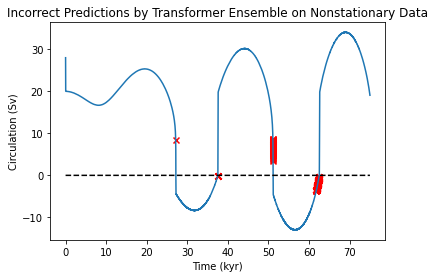

In [209]:
fig, ax = plt.subplots()
ax.plot(input_data[:, 0], qplot/Sv)
ax.plot(input_data[:, 0], np.zeros_like(input_data[:, 0]), 'k--')
ax.set_title('Incorrect Predictions by Transformer Ensemble on Nonstationary Data')
ax.scatter(input_data[false_indices, 0], qplot[false_indices]/Sv, marker='x', c='red')
ax.set_xlabel('Time (kyr)')
ax.set_ylabel('Circulation (Sv)')
fig.savefig('figures/training/preds_all_transformer_ns.pdf')

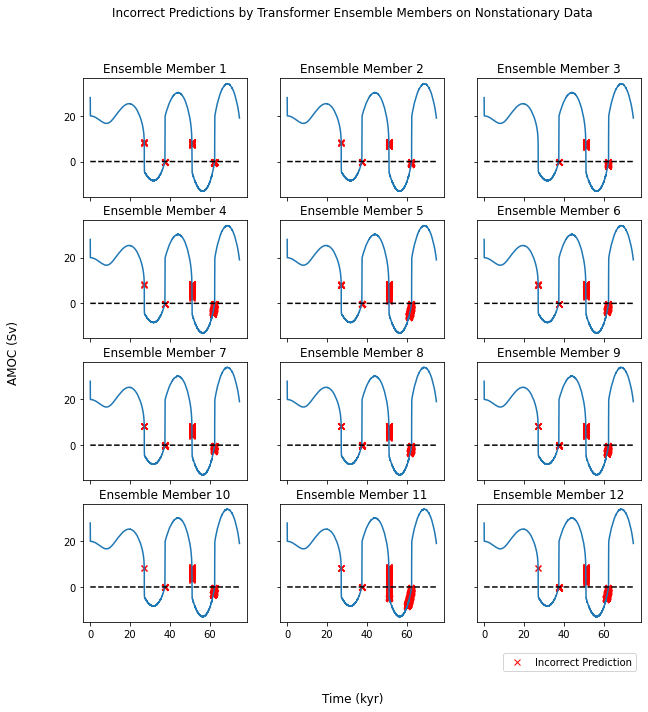

In [210]:
fig, ax = plt.subplots(4, 3, sharex = True, sharey = True, figsize = (10, 10))
fig.supxlabel('Time (kyr)')
fig.supylabel('AMOC (Sv)')
fig.suptitle('Incorrect Predictions by Transformer Ensemble Members on Nonstationary Data')
ax = ax.flatten()
for i in range(12):
    ensemble_i_pred = (predicted_results_ensemble[i] > 0.5).astype(int)
    false_indices = []
    for j in range(len(ensemble_i_pred)):
        if ensemble_i_pred[j] != output_seq[j]:
            false_indices.append(j)
    ax[i].plot(input_data[:, 0], qplot/Sv);
    ax[i].plot(input_data[:, 0], input_data[:, 0]*0,'k--');
    ax[i].set_title('Ensemble Member ' + str(i+1));
    ax[i].scatter([input_data[:, 0][k] for k in false_indices], [qplot[k]/Sv for k in false_indices], marker='x', c='red');
red_x = mlines.Line2D([], [], color='red', marker='x', linestyle='None', label='Incorrect Prediction')
fig.legend(handles=[red_x], loc='lower right', bbox_to_anchor=(0.9, 0.05))
fig.savefig('figures/training/preds_ensemble_transformer_ns.pdf')

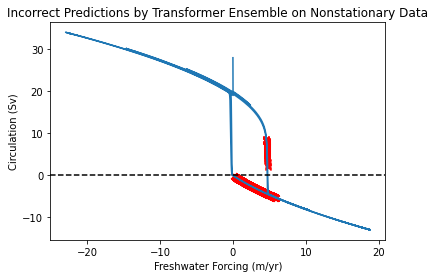

In [211]:
fig, ax = plt.subplots()
ax.plot(input_data[:, 3]/Fs_to_m_per_year, qplot/Sv)
ax.axhline(0, color='black', linestyle='--');
ax.set_title('Incorrect Predictions by Transformer Ensemble on Nonstationary Data')
ax.scatter(input_data[false_indices, 3]/Fs_to_m_per_year, qplot[false_indices]/Sv, marker='x', c='red')
ax.set_xlabel('Freshwater Forcing (m/yr)')
ax.set_ylabel('Circulation (Sv)')
fig.savefig('figures/training/preds_all_transformer_ns_hysteresis.pdf')

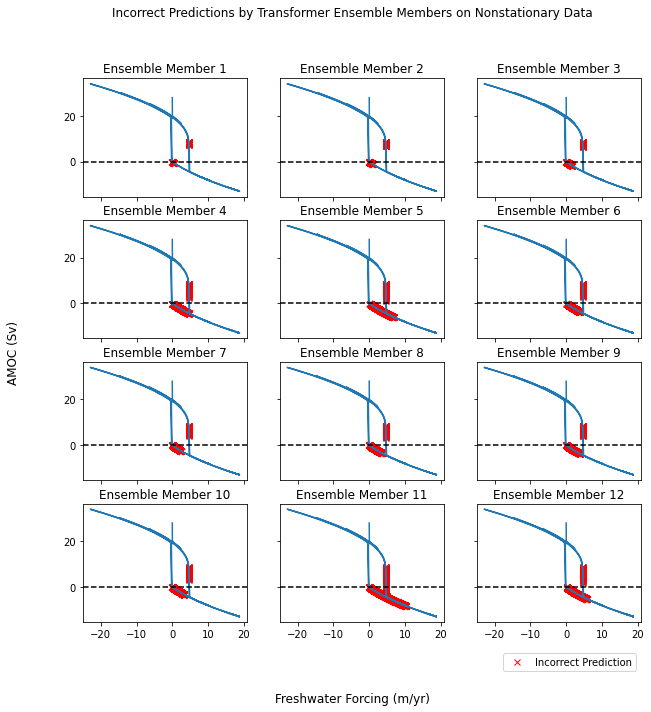

In [212]:
fig, ax = plt.subplots(4, 3, sharex = True, sharey = True, figsize = (10, 10))
fig.supxlabel('Freshwater Forcing (m/yr)')
fig.supylabel('AMOC (Sv)')
fig.suptitle('Incorrect Predictions by Transformer Ensemble Members on Nonstationary Data')
ax = ax.flatten()
for i in range(12):
    ensemble_i_pred = (predicted_results_ensemble[i] > 0.5).astype(int)
    false_indices = []
    for j in range(len(ensemble_i_pred)):
        if ensemble_i_pred[j] != output_seq[j]:
            false_indices.append(j)
    ax[i].plot(input_data[:, 3]/Fs_to_m_per_year, qplot/Sv);
    ax[i].axhline(0, color='black', linestyle='--');
    ax[i].set_title('Ensemble Member ' + str(i+1));
    ax[i].scatter([input_data[:, 3][k]/Fs_to_m_per_year for k in false_indices], [qplot[k]/Sv for k in false_indices], marker='x', c='red');
red_x = mlines.Line2D([], [], color='red', marker='x', linestyle='None', label='Incorrect Prediction')
fig.legend(handles=[red_x], loc='lower right', bbox_to_anchor=(0.9, 0.05))
fig.savefig('figures/training/preds_ensemble_transformer_ns_hysteresis.pdf')

In [165]:
test_indices = set(range(81992, 100000))
train_indices = set(range(0, 60032))
val_indices = set(range(61024, 81000))
wrong_in_test = list(set(false_indices) & test_indices)
wrong_in_train = list(set(false_indices) & train_indices)
wrong_in_val = list(set(false_indices) & val_indices)
np.save('incorrect_indices_transformer_ns', np.array(wrong_in_test))

In [171]:
np.save('incorrect_indices_transformer_ns', np.array(wrong_in_test))

In [170]:
len(wrong_in_test)

1285

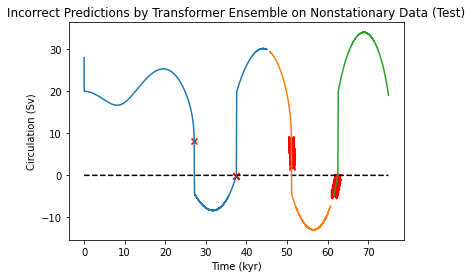

In [169]:
fig, ax = plt.subplots()
ax.plot(input_data[:, 0], np.zeros_like(input_data[:, 0]), 'k--')
ax.plot(X_train[:, 0], qplot[0:60032]/Sv);
ax.plot(X_val[:, 0], qplot[61024:81000]/Sv);
ax.plot(X_test[:, 0], qplot[81992:100000]/Sv);
ax.set_title('Incorrect Predictions by Transformer Ensemble on Nonstationary Data (Test)');
ax.scatter(input_data[wrong_in_test, 0], qplot[wrong_in_test]/Sv, marker='x', c='red');
ax.scatter(input_data[wrong_in_train, 0], qplot[wrong_in_train]/Sv, marker='x', c='red');
ax.scatter(input_data[wrong_in_val, 0], qplot[wrong_in_val]/Sv, marker='x', c='red');
ax.set_xlabel('Time (kyr)');
ax.set_ylabel('Circulation (Sv)');

In [ ]:
fig, ax = plt.subplots()
ax.plot(X_train[:, 0], qplot[81992:100000]/Sv);
ax.plot(X_test[:, 0], np.zeros_like(X_test[:, 0]), 'k--')
ax.set_title('Incorrect Predictions by Transformer Ensemble on Nonstationary Data (Test)')
ax.scatter(input_data[wrong_in_test, 0], qplot[wrong_in_test]/Sv, marker='x', c='red')
ax.set_xlabel('Time (kyr)')
ax.set_ylabel('Circulation (Sv)')